In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import division
import random
import scipy
import h5py
import hdf5storage

In [3]:
## random seed will dictate the random initialization
sd=30000
np.random.seed(sd)

In [4]:
maxker=28
traindatapath='/home/ubuntu/Notebooks/Circuit2_Training_Data.h5'
data = hdf5storage.loadmat(traindatapath)


x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = reshape(data['y_test'], [1, 2000])

gc_bias_init = data['gc_bias']
bipkernels = data['bipkernels']
bip_gc_syn_init = data['bip_gc_syn']
bip_am_syn_init = data['bip_am_syn']
am_gc_syn_init = data['am_gc_syn']

#sparsity params for weight matrix initializations
init_sparsity = 0.0 
init_sparsity_bg = 0.01


bip_gc_syn_mask1 = np.random.rand(maxker*100, 1)
bip_gc_syn_mask1 = reshape(bip_gc_syn_mask1, [1, 10, 10, maxker])
bip_gc_syn_mask1 = bip_gc_syn_mask1 >(1.0 - init_sparsity_bg)


bip_gc_syn_init_full = np.zeros([1, 10, 10, maxker])
bip_gc_syn_mask_true = reshape(bip_gc_syn_init, [1, 10, 10, 3])>0.0
bip_gc_syn_init_full[:, :, :, 0:3] = bip_gc_syn_mask_true

bip_gc_syn_mask = np.maximum(bip_gc_syn_mask1, bip_gc_syn_init_full)

bip_gc_syn_init11 = tf.random_uniform([1, 10, 10, maxker], minval=0.1, maxval=0.2, dtype=tf.float32)
bip_gc_syn_init1=bip_gc_syn_init11

bip_am_syn_mask = np.zeros([10, 10, maxker, 5, 5])
for i in range(10):
    for j in range(10):
        for k in range(maxker):
            bip_am_syn_mask[i, j, k, int(floor(i/2)), int(floor(j/2))] = 1.0
bip_am_syn_mask = bip_am_syn_mask.astype(float32)


bip_am_syn_inds = np.zeros([maxker*100, 6])
for i in range(10):
    for j in range(10):
        for k in range(maxker):
            bip_am_syn_inds[maxker*10*(i)+28*(j)+k]=[0, i, j, k, floor(i/2), floor(j/2)]
bip_am_syn_inds = bip_am_syn_inds.astype(int64)


bip_am_syn_init11 = np.random.normal(0.0, (sqrt(2.0)/112.0), size=[maxker*100])
bip_am_syn_init11=bip_am_syn_init11.astype(float32)        

am_gc_syn_init1 = tf.random_uniform([1, 5, 5], minval=0.1, maxval=0.2, dtype=tf.float32)
 

print(shape(x_train))
print(shape(x_test))
print(shape(bip_gc_syn_init))

sum(bip_am_syn_mask)

(98000, 100, 100, 1)
(2000, 100, 100, 1)
(1, 10, 10, 3)


2800.0

(1, 98000)
(1, 2000)


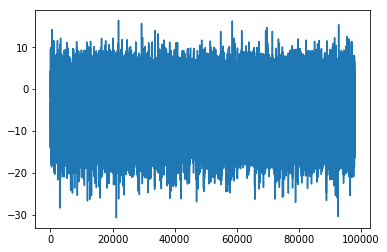

In [5]:
print(shape(y_train))
print(shape(y_test))
plt.figure()
plt.plot(squeeze(y_train))

In [6]:
def bias_var(shape, initial_val):
    initial = tf.constant(initial_val, shape=shape)
    return tf.constant(initial_val) #initial

def bip_conv2d(x, W):
    padsize=10 
    paddedx=tf.pad(x, [[0, 0], [padsize, padsize], [padsize, padsize], [0, 0]], 'CONSTANT')
    outconv=tf.nn.conv2d(paddedx, W, strides=[1, 10, 10, 1], padding='SAME') #250 for movingdot and noise
    return outconv[:, 1:11, 1:11, :]

def synapse_var(shape, initial_val):
#      initial=tf.constant(initial_val, shape=shape)
#     initial = tf.random_uniform(shape, minval=0.1, maxval=0.8, dtype=tf.float32)
    return tf.Variable(initial_val)


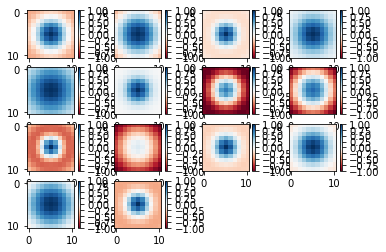

In [7]:
## create layer 1 convolutional kernels (difference of gaussians)

def difference_of_gaussians(ctr_sigma, surr_sigma, ctr_strength, surr_strength, x, y):
    
    center=0.4*(1/ctr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/ctr_sigma))
    
    surround=0.4*(1/surr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/surr_sigma))
    
    kernel = ctr_strength*center - surr_strength*surround
    
    maxk = amax(abs(kernel)) #normalization factor
    
    return kernel/maxk


x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
xv, yv = np.meshgrid(x, y)

bipkernels = np.zeros([11, 11, 1, maxker])


kernel1 = difference_of_gaussians(3, 6, 13, 12.9, xv, yv) 
kernel2 = difference_of_gaussians(5, 6, 18, 18, xv, yv)
kernel3 = difference_of_gaussians(2, 4, 20, 14, xv, yv)
kernel4 = difference_of_gaussians(3, 6, 13, 0, xv, yv)
kernel5 = difference_of_gaussians(4, 6, 13, 0, xv, yv) 
kernel6 = difference_of_gaussians(2, 4, 20, 0, xv, yv)

kernel7 = difference_of_gaussians(3, 6, 13, 20, xv, yv)
kernel8 = difference_of_gaussians(5, 6, 18, 20, xv, yv) 
kernel9 = difference_of_gaussians(2, 4, 20, 24, xv, yv)

kernel10 = difference_of_gaussians(5, 8, 13, 20, xv, yv)
kernel11 = difference_of_gaussians(2, 8, 15, 15, xv, yv)
kernel12 = difference_of_gaussians(3, 8, 20, 12, xv, yv)
kernel13 = difference_of_gaussians(5, 8, 20, 18, xv, yv)
kernel14 = difference_of_gaussians(2, 8, 13, 18, xv, yv)


bipkernels[:, :, 0, 0]=kernel1
bipkernels[:, :, 0, 1]=kernel2
bipkernels[:, :, 0, 2]=kernel3
bipkernels[:, :, 0, 3]=kernel4
bipkernels[:, :, 0, 4]=-1.0*kernel1
bipkernels[:, :, 0, 5]=-1.0*kernel2
bipkernels[:, :, 0, 6]=-1.0*kernel3
bipkernels[:, :, 0, 7]=-1.0*kernel4
bipkernels[:, :, 0, 8]=kernel5
bipkernels[:, :, 0, 9]=kernel6
bipkernels[:, :, 0, 10]=kernel7
bipkernels[:, :, 0, 11]=kernel8
bipkernels[:, :, 0, 12]=-1.0*kernel5
bipkernels[:, :, 0, 13]=-1.0*kernel6
bipkernels[:, :, 0, 14]=-1.0*kernel7
bipkernels[:, :, 0, 15]=-1.0*kernel8
bipkernels[:, :, 0, 16]=kernel9
bipkernels[:, :, 0, 17]=kernel10
bipkernels[:, :, 0, 18]=kernel11
bipkernels[:, :, 0, 19]=kernel12
bipkernels[:, :, 0, 20]=-1.0*kernel9
bipkernels[:, :, 0, 21]=-1.0*kernel10
bipkernels[:, :, 0, 22]=-1.0*kernel11
bipkernels[:, :, 0, 23]=-1.0*kernel12
bipkernels[:, :, 0, 24]=kernel13
bipkernels[:, :, 0, 25]=kernel14
bipkernels[:, :, 0, 26]=-1.0*kernel13
bipkernels[:, :, 0, 27]=-1.0*kernel14




plt.figure()
plt.subplot(4, 4, 1)
plt.imshow(kernel1, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 2)
plt.imshow(kernel2, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 3)
plt.imshow(kernel3, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 4)
plt.imshow(kernel4, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 5)
plt.imshow(kernel5, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 6)
plt.imshow(kernel6, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 7)
plt.imshow(kernel7, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 8)
plt.imshow(kernel8, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 9)
plt.imshow(kernel9, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 10)
plt.imshow(kernel10, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 11)
plt.imshow(kernel11, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 12)
plt.imshow(kernel12, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 13)
plt.imshow(kernel13, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 14)
plt.imshow(kernel14, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()


    


    

In [8]:

sess=tf.Session()
sess.run(tf.global_variables_initializer())  



In [9]:
kernels = [3, 8, 16, 28]
lambdas = [1e1, 1e1, 1e1, 1e1] # knowledge 0.2

datas = [60, 340, 700, 1400, 2800, 5500, 11000, 22000, 98000]
training_epochs = [6000, 4000, 4000, 3000, 3000, 2000, 2000, 1000, 500]
test_sizes = [2080, 2080, 2080, 2080, 2080, 2080, 2080, 2080, 2080, 2000]

learn_rate = 1e-3
learn_rate_late = 1e-4


for i_data in range(7):
    
    for i_kernel in range(4): 
        
        if i_kernel > 0: 
            del stimulus_
            del bipolar_cell_layer
            del gc_activation
            del gc_output
            del bipolar_bias
            del bipkernels1
        
        no_train=datas[i_data]
        epochs = training_epochs[i_data]
        no_kernels = kernels[i_kernel]
        lambda1 = lambdas[i_kernel]
        bipkernels1 = bipkernels[:, :, :, 0:no_kernels]
        bip_gc_syn_init = bip_gc_syn_init1[:, :, :, 0:no_kernels]
        bip_am_syn_mask1 = bip_am_syn_mask[ :, :, 0:no_kernels, :, :]
        
        
        no_test=test_sizes[i_data] 
        no_bipolars = 10
        no_amacrines = 5

        wheretosave = '/home/ubuntu/Notebooks/Circuit2_Trained_Network_data' + str(no_train) + '_kernel' + str(no_kernels) \
        + '_sd' + str(sd) + '_nosignconstraint.mat'

        ## initialize all variables

        bip_bias_init_all = -1.0*np.ones([28])
        bip_bias_init_all[0]=-2.0
        bip_bias_init_all[1]=-3.0
        bip_bias_init_all[3]=-15.0
        bip_bias_init_all[8]=-25.0
        bip_bias_init_all[9]=-10.0
        
        bip_bias_init_all[4]=-2.0
        bip_bias_init_all[5]=-3.0
        bip_bias_init_all[7]=-15.0
        bip_bias_init_all[12]=-25.0
        bip_bias_init_all[13]=-10.0

        

        bip_bias_init = bip_bias_init_all[0:no_kernels]
        bip_bias_init = bip_bias_init.astype(float32)
        bipolar_bias = bias_var([no_kernels], bip_bias_init)
        
        am_bias_init = -5.0 
        am_bias = bias_var([1], am_bias_init)
        
        gc_bias = bias_var([1], gc_bias_init)
        
        bip_gc_syn_init=tf.random.normal([1, no_bipolars, no_bipolars, no_kernels], mean = 0.0, stddev = sqrt(2.0/(no_kernels*100)), dtype=tf.dtypes.float32, seed=sd)
        bip_gc_syn = synapse_var([1, no_bipolars, no_bipolars, no_kernels], bip_gc_syn_init)
        
        bip_am_syn_inds = np.zeros([no_kernels*100, 6])
        for i in range(10):
            for j in range(10):
                for k in range(no_kernels):
                    bip_am_syn_inds[no_kernels*10*(i)+no_kernels*(j)+k]=[0, i, j, k, floor(i/2), floor(j/2)]
        bip_am_syn_inds = bip_am_syn_inds.astype(int64)
        bip_am_syn_init11 = np.random.normal(0.0, (sqrt(2.0/no_kernels)), size=[no_kernels*100])
        bip_am_syn_init111=bip_am_syn_init11.astype(float32)  
        bip_am_syn_val = synapse_var([no_kernels*no_bipolars*no_bipolars], bip_am_syn_init111)
        bip_am_syn1 = tf.sparse.SparseTensor(indices=bip_am_syn_inds, values=bip_am_syn_val, dense_shape=[1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])
        bip_am_syn = tf.sparse.to_dense(tf.sparse.reorder(bip_am_syn1))        

        am_gc_syn = synapse_var([1, no_amacrines, no_amacrines], am_gc_syn_init1)

        stimulus_ = tf.placeholder("float32", name="stim_placeholder")

        bipolar_cell_layer = tf.nn.relu(tf.nn.bias_add(bip_conv2d(stimulus_, bipkernels1), bipolar_bias))

        biplyr = tf.reshape(bipolar_cell_layer, [-1, no_bipolars*no_bipolars*no_kernels, 1])

        tilebip_am_syn=tf.tile(tf.transpose(tf.reshape(bip_am_syn, [1, no_bipolars*no_bipolars*no_kernels, no_amacrines*no_amacrines]), [0, 2, 1]), [1, 1, 1])

        amacrine_activation = 3.0*tf.reshape(tf.linalg.matmul(tilebip_am_syn, biplyr), [-1,no_amacrines, no_amacrines])
     
        amacrine_cell_layer = tf.nn.relu(tf.add(amacrine_activation, am_bias))

        gc_activation = tf.multiply(bip_gc_syn, bipolar_cell_layer)

        gc_activation_inhib = tf.multiply(am_gc_syn, amacrine_cell_layer)

        gc_output = tf.add_n([tf.reduce_sum(gc_activation, [1, 2, 3]), tf.reduce_sum(gc_activation_inhib, [1, 2])])

        ## training procedure
        y_ = tf.placeholder("float32", name="output_spikes")
        
        batchsize=20

        loss = (tf.nn.l2_loss((tf.squeeze(gc_output) - tf.squeeze(y_)), name='loss'))

        regularizer=tf.add_n([tf.reduce_sum(tf.abs(bip_am_syn)), tf.reduce_sum(tf.abs(bip_gc_syn)), \
                              0.0*tf.reduce_sum(tf.abs(am_gc_syn))])

        objective=tf.add(loss, lambda1*regularizer)
        
        bip_am_ygrad = tf.gradients(loss, [bip_am_syn])
        bip_am_reggrad = tf.gradients(regularizer, [bip_am_syn])
        
        am_gc_ygrad = tf.gradients(loss, [am_gc_syn])
        am_gc_reggrad = tf.gradients(regularizer, [am_gc_syn])
        
        bip_gc_ygrad = tf.gradients(loss, [bip_gc_syn])
        bip_gc_reggrad = tf.gradients(regularizer, [bip_gc_syn])
        


        algorithm_choice=2
        lr_min = 1e-4
        lr_max = 1e-5
        max_step =500
        lr_ = tf.placeholder("float32", name="learn_rate")
        
        if algorithm_choice==1:
            train_step = tf.train.GradientDescentOptimizer(lr_).minimize(objective)
        elif algorithm_choice==2:
            my_epsilon=1e-8
            train_step = tf.train.AdamOptimizer(learning_rate=lr_, epsilon=my_epsilon).minimize(objective)
        elif algorithm_choice==3:
            momentum_par=0.9
            train_step = tf.train.MomentumOptimizer(lr_, momentum_par).minimize(objective)
        elif algorithm_choice==4:
            train_step = tf.train.AdagradOptimizer(lr_).minimize(objective)
        elif algorithm_choice==5:
            train_step = tf.train.RMSPropOptimizer(lr_).minimize(objective)
            

        sess.run(tf.global_variables_initializer())    

        bip_gc_syn_hist=tf.reshape(bip_gc_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels]) 
        bip_am_syn_hist=tf.reshape(bip_am_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        am_gc_syn_hist=tf.reshape(am_gc_syn.eval(session=sess), [1, no_amacrines, no_amacrines]) 
        train_loss_hist = ones([1])
        test_loss_hist = ones([1])
        
        bip_am_ygrad_hist=np.reshape(sess.run(bip_am_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        bip_am_reggrad_hist=np.reshape(sess.run(bip_am_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        am_gc_ygrad_hist=np.reshape(sess.run(am_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])
        am_gc_reggrad_hist=np.reshape(sess.run(am_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])
        bip_gc_ygrad_hist=np.reshape(sess.run(bip_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels]) 
        bip_gc_reggrad_hist=np.reshape(sess.run(bip_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels]) 

        train_fd={stimulus_: x_train[0:50, :, :, :]}
        test_fd={stimulus_: x_test[0:50, :, :, :]}
        train_output_hist=reshape(gc_output.eval(session=sess, feed_dict=train_fd), [1, 50])
        test_output_hist=reshape(gc_output.eval(session=sess, feed_dict=test_fd), [1, 50])
        
        
        check=1.0
        step=0
        end_flag=0

        fd = {stimulus_:x_train[0:100, :, :, :], y_:y_train[0, 0:100]}
        train_loss_val = sess.run(loss, feed_dict = fd)
        print(train_loss_val)

        fd = {stimulus_:x_test[0:100, :, :, :], y_:y_test[0, 0:100]}
        test_loss_val = sess.run(loss, feed_dict = fd)
        print(test_loss_val)



        train_loss_hist=train_loss_val*train_loss_hist
        test_loss_hist=test_loss_val*test_loss_hist

        
        endflag=0
        step=0
        while endflag == 0:
            #learning rate schedule
            learn_rate_sch = lr_min + 0.5*(lr_max - lr_min)*(1.0+np.cos(np.pi*(step%max_step/max_step))) 
            if step>=10*max_step:
                learn_rate_sch = lr_min

            inds = np.reshape(np.random.permutation(range(no_train)), [-1, batchsize])
            for n in range(len(inds)): 
                fdd = {stimulus_: x_train[inds[n, :], :, :, :], y_: y_train[0, inds[n, :]], lr_: learn_rate_sch} 
                                                                 
                sess.run(train_step, feed_dict=fdd)

                        
            if (step % 100 ==0):

                train_loss_val = sess.run(loss, feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]})/100.0
                test_loss_val = sess.run(loss, feed_dict= {stimulus_: x_test[0:100, :, :, :], y_: y_test[0, 0:100]})/100.0
                print("step: %d  loss: = %9f" % (step, train_loss_val))

                bip_gc_syn_hist=tf.concat( [bip_gc_syn_hist, tf.reshape(bip_gc_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels])], 0,  name='bip_gc_syn_concat')
                bip_am_syn_hist=tf.concat( [bip_am_syn_hist, tf.reshape(bip_am_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0,  name='bip_am_syn_concat')
                am_gc_syn_hist=tf.concat( [am_gc_syn_hist, tf.reshape(am_gc_syn.eval(session=sess), [1, no_amacrines, no_amacrines])], 0,  name='am_gc_syn_concat')

                bip_am_ygrad_hist=tf.concat( [bip_am_ygrad_hist, np.reshape(sess.run(bip_am_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0)
                bip_am_reggrad_hist=tf.concat( [bip_am_reggrad_hist, np.reshape(sess.run(bip_am_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0)
                am_gc_ygrad_hist=tf.concat( [am_gc_ygrad_hist, np.reshape(sess.run(am_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])], 0)
                am_gc_reggrad_hist=tf.concat( [am_gc_reggrad_hist, np.reshape(sess.run(am_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])], 0)
                bip_gc_ygrad_hist=tf.concat( [bip_gc_ygrad_hist, np.reshape(sess.run(bip_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels])], 0)
                bip_gc_reggrad_hist=tf.concat( [bip_gc_reggrad_hist, np.reshape(sess.run(bip_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels])], 0)

                train_loss_hist=np.concatenate([train_loss_hist, np.array([train_loss_val])], axis=0)
                test_loss_hist=np.concatenate([test_loss_hist, np.array([test_loss_val])], axis=0)
                
                train_fd={stimulus_: x_train[0:50, :, :, :]}
                test_fd={stimulus_: x_test[0:50, :, :, :]}
                train_output=reshape(gc_output.eval(session=sess, feed_dict=train_fd), [1, 50])
                test_output=reshape(gc_output.eval(session=sess, feed_dict=test_fd), [1, 50])
                
                train_output_hist=np.concatenate([train_output_hist, train_output], axis=0)
                test_output_hist=np.concatenate([test_output_hist, test_output], axis=0)
                
                #stopping condition
                if (step/100)>=5:
                    b=np.diff(train_loss_hist[int(step/100-5):int(step/100)])
                    a=abs(b)<1.0
                    c=b>0.0
                    if sum(c)>=3:
                        endflag=1
            step = step + 1

        db = {}

        db['bipolar_bias'] = bipolar_bias.eval(session=sess)
        db['bip_gc_syn_hist'] = bip_gc_syn_hist.eval(session=sess)
        db['bip_am_syn_hist'] = bip_am_syn_hist.eval(session=sess)
        db['am_gc_syn_hist'] = am_gc_syn_hist.eval(session=sess)
        db['gc_bias'] = gc_bias.eval(session=sess)
        
        db['bip_am_ygrad_hist'] = bip_am_ygrad_hist.eval(session=sess)
        db['bip_am_reggrad_hist'] = bip_am_reggrad_hist.eval(session=sess)
        db['am_gc_ygrad_hist'] = am_gc_ygrad_hist.eval(session=sess)
        db['am_gc_reggrad_hist'] = am_gc_reggrad_hist.eval(session=sess)
        db['bip_gc_ygrad_hist'] = bip_gc_ygrad_hist.eval(session=sess)
        db['bip_gc_reggrad_hist'] = bip_gc_reggrad_hist.eval(session=sess)



        db['no_train']=no_train
        db['no_test']=no_test

        db['no_kernels'] = no_kernels
        db['no_bipolars']=no_bipolars

        db['bipkernels'] = bipkernels
        db['randomseed'] = sd

        db['train_output_hist'] = train_output_hist
        db['test_output_hist'] = test_output_hist

        db['algorithm_choice'] = algorithm_choice
        db['learn_rate'] = learn_rate
        db['lambda'] = lambda1

        db['train_loss_hist'] = train_loss_hist
        db['test_loss_hist'] = test_loss_hist                          

        struct_proj = np.zeros([len(train_loss_hist), 1])

        syn_hist = bip_gc_syn_hist.eval(session=sess)
        basyn_hist = bip_am_syn_hist.eval(session=sess)
        agsyn_hist = am_gc_syn_hist.eval(session=sess)
        
        truesyn = np.zeros([10, 10, no_kernels])
        
        truebasyn = np.zeros([no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])
        truebasyn[:, :, 0:3, :, :]=bip_am_syn_init
        
        trueagsyn=am_gc_syn_init
        
        norm_factor = (np.sum(np.square(truebasyn)) + np.sum(np.square(trueagsyn)))
        for i in range(len(train_loss_hist)):
            norm_factor = (np.sum(np.square(basyn_hist[i, :, :, :, :, :])) + np.sum(np.square(agsyn_hist[i, :, :])))
            struct_proj[i] = (np.sum(np.multiply((basyn_hist[i, :, :, :, :, :]), truebasyn))+np.sum(np.multiply((agsyn_hist[i, :, :]), trueagsyn)))/norm_factor

        db['struct_proj'] = struct_proj

        sio.savemat(wheretosave, db)
        
        print("completed data: %d  kernels: = %9f" % (no_train, no_kernels))
        

90761.33
100538.164
step: 0  loss: = 906.600937
step: 100  loss: = 787.125625
step: 200  loss: = 570.873359
step: 300  loss: = 312.133984
step: 400  loss: = 141.789902
step: 500  loss: = 77.060488
step: 600  loss: = 72.803896
step: 700  loss: = 64.632666
step: 800  loss: = 54.524731
step: 900  loss: = 45.200762
step: 1000  loss: = 36.854248
step: 1100  loss: = 35.803574
step: 1200  loss: = 33.335901
step: 1300  loss: = 28.939253
step: 1400  loss: = 23.605337
step: 1500  loss: = 18.866896
step: 1600  loss: = 18.313175
step: 1700  loss: = 17.054845
step: 1800  loss: = 14.949138
step: 1900  loss: = 12.597913
step: 2000  loss: = 10.664016
step: 2100  loss: = 10.445200
step: 2200  loss: =  9.943916
step: 2300  loss: =  9.090223
step: 2400  loss: =  8.110783
step: 2500  loss: =  7.277394
step: 2600  loss: =  7.177250
step: 2700  loss: =  6.953016
step: 2800  loss: =  6.570938
step: 2900  loss: =  6.097966
step: 3000  loss: =  5.657791
step: 3100  loss: =  5.606224
step: 3200  loss: =  5.4857

step: 1900  loss: =  1.119696
step: 2000  loss: =  1.077324
step: 2100  loss: =  1.076325
step: 2200  loss: =  1.068903
step: 2300  loss: =  1.060232
step: 2400  loss: =  1.055493
step: 2500  loss: =  1.077285
step: 2600  loss: =  1.078442
step: 2700  loss: =  1.076683
step: 2800  loss: =  1.075094
step: 2900  loss: =  1.063824
step: 3000  loss: =  1.045768
step: 3100  loss: =  1.044686
step: 3200  loss: =  1.039047
step: 3300  loss: =  1.032616
step: 3400  loss: =  1.020092
step: 3500  loss: =  1.011448
step: 3600  loss: =  1.010396
step: 3700  loss: =  1.005650
step: 3800  loss: =  0.999718
step: 3900  loss: =  0.995678
step: 4000  loss: =  0.993050
step: 4100  loss: =  0.994921
step: 4200  loss: =  0.993672
step: 4300  loss: =  0.991434
step: 4400  loss: =  0.988960
step: 4500  loss: =  0.985859
step: 4600  loss: =  0.986708
step: 4700  loss: =  0.985243
step: 4800  loss: =  0.984226
step: 4900  loss: =  0.979380
step: 5000  loss: =  0.981954
step: 5100  loss: =  0.978908
step: 5200

step: 1200  loss: =  0.758227
step: 1300  loss: =  0.744133
step: 1400  loss: =  0.734927
step: 1500  loss: =  0.753542
step: 1600  loss: =  0.752607
step: 1700  loss: =  0.769413
step: 1800  loss: =  0.752476
step: 1900  loss: =  0.787823
step: 2000  loss: =  0.753505
step: 2100  loss: =  0.747035
step: 2200  loss: =  0.743865
step: 2300  loss: =  0.748402
step: 2400  loss: =  0.784137
step: 2500  loss: =  0.750234
step: 2600  loss: =  0.751050
step: 2700  loss: =  0.750142
step: 2800  loss: =  0.733373
completed data: 700  kernels: = 16.000000
208816.7
234310.38
step: 0  loss: = 1923.450000
step: 100  loss: = 94.152090
step: 200  loss: = 13.475408
step: 300  loss: =  2.358350
step: 400  loss: =  1.314632
step: 500  loss: =  0.966291
step: 600  loss: =  0.999237
step: 700  loss: =  0.955525
step: 800  loss: =  0.856224
step: 900  loss: =  0.826904
step: 1000  loss: =  0.815485
step: 1100  loss: =  0.832569
step: 1200  loss: =  0.847845
step: 1300  loss: =  0.814580
step: 1400  loss: =

step: 1100  loss: =  1.045967
step: 1200  loss: =  0.940503
step: 1300  loss: =  1.010814
completed data: 5500  kernels: = 28.000000
50759.69
71028.34
step: 0  loss: = 401.179336
step: 100  loss: =  1.472515
step: 200  loss: =  1.025870
step: 300  loss: =  0.960902
step: 400  loss: =  0.961560
step: 500  loss: =  0.965563
step: 600  loss: =  0.959412
step: 700  loss: =  0.951688
step: 800  loss: =  0.950056
step: 900  loss: =  0.953716
step: 1000  loss: =  0.953670
step: 1100  loss: =  0.955128
step: 1200  loss: =  0.957468
step: 1300  loss: =  0.977640
step: 1400  loss: =  0.960708
completed data: 11000  kernels: =  3.000000
71621.336
80588.92
step: 0  loss: = 473.811680
step: 100  loss: =  1.192201
step: 200  loss: =  0.907570
step: 300  loss: =  0.853495
step: 400  loss: =  0.830141
step: 500  loss: =  0.834479
step: 600  loss: =  0.840843
step: 700  loss: =  0.824005
step: 800  loss: =  0.872129
step: 900  loss: =  0.834649
step: 1000  loss: =  0.824585
completed data: 11000  kerne

In [11]:
fd=feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}
train_output=gc_output.eval(session=sess, feed_dict=fd)
print(train_output)

fd=feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}
train_output=amacrine_cell_layer.eval(session=sess, feed_dict=fd)
print(train_output)

[ -1.4228064    0.6416717   -7.954151    -7.1236005   -8.948158
  -3.4573846   -1.6151704    0.8720955   -5.1968794   -5.343743
  -4.679883    -5.180412    -6.1150255   -0.5158843   -2.3922982
  -6.2199106   -0.44152528  -2.5907264   -4.4703307   -5.9195175
   1.0567964   -7.220103    -0.75077546   0.13780445  -3.358344
   0.52748483  -1.9693136  -13.426476    -2.278798    -5.4695296
  -4.5002356   -6.812718    -2.0966468   -8.701207     1.0634787
  -8.707906     5.1430945   -1.2696398  -12.205326    -3.801906
   0.29879776  -0.28056496  -1.2217234   -5.2528863    1.0899161
  -9.754969    -6.4723225   -1.5638349    3.5947518    0.46535856
  -0.35739198   0.07319409  -2.579593    -5.58231     -6.6857977
  -1.7683878   -2.1197047   -6.2449265   -5.120393    -7.956409
  -5.783134    -4.958048    -1.6125269    1.1362497   -5.9084387
  -2.8033814   -1.1789311    1.4857316   -4.264687    -4.833137
  -8.886445    -3.803897    -5.945573    -4.5016975   -0.21387231
  -4.860885    -1.700955    -